In [1]:
import time      
from timeit import default_timer as timer 
import torch
import torch.nn as nn
from   torch.nn import functional as F
import  os
import  numpy as np
import  argparse
import  scipy.io as sio                                # Read the .mat file; the sio submodule provides functions for reading and writing MATLAB files.            
import math
import matplotlib.pyplot as plt

## Multilayer Perceptron Design

In [2]:
class Basicblock(nn.Module):       
    def __init__(self,in_planes,out_planes):
        super(Basicblock, self).__init__()
        self.layer = nn.Linear(in_planes,out_planes)

    def forward(self, x):
        out = torch.sin(self.layer(x))    
        return out

class PhysicsInformedNN(nn.Module):
    def __init__(self, layers):
        super(PhysicsInformedNN, self).__init__()
        self.layers = layers
        self.in_planes = self.layers[0]
        self.layer1 = self._make_layer(Basicblock,self.layers[1:len(layers)-1])   
        self.layer2 = nn.Linear(layers[-2],layers[-1])
 
    def _make_layer(self, block, layers):     
        layers_net = []
        for layer in layers:
            layers_net.append(block(self.in_planes,layer))
            self.in_planes = layer
        return nn.Sequential(*layers_net)

    def forward(self,x):
        out = self.layer1(x)                 
        out = self.layer2(out)
        return out[:, 0:1], out[:, 1:2]      

## Use automatic differentiation to compute the derivatives of the wavefield with respect to x and z

In [3]:
def calculate_grad(x, z, du_real, du_imag):
    """
    calculate the gradients of du_real and du_imag versus database
    """        
    # real scattered wavefield
    du_real_x = torch.autograd.grad(du_real, x, grad_outputs=torch.ones_like(du_real),create_graph=True)[0]   #grad_outputs: 
    du_real_z = torch.autograd.grad(du_real, z, grad_outputs=torch.ones_like(du_real),create_graph=True)[0]
    du_real_xx = torch.autograd.grad(du_real_x, x, grad_outputs=torch.ones_like(du_real_x),create_graph=True)[0]
    du_real_zz = torch.autograd.grad(du_real_z, z, grad_outputs=torch.ones_like(du_real_z),create_graph=True)[0]

    # imag scattered wavefield
    du_imag_x = torch.autograd.grad(du_imag, x, grad_outputs=torch.ones_like(du_imag),create_graph=True)[0]
    du_imag_z = torch.autograd.grad(du_imag, z, grad_outputs=torch.ones_like(du_imag),create_graph=True)[0]
    du_imag_xx = torch.autograd.grad(du_imag_x, x, grad_outputs=torch.ones_like(du_imag_x),create_graph=True)[0]
    du_imag_zz = torch.autograd.grad(du_imag_z, z, grad_outputs=torch.ones_like(du_imag_z),create_graph=True)[0]

    return du_real_xx, du_real_zz, du_imag_xx, du_imag_zz

## Build loss 

In [4]:
class PINNLoss(nn.Module):
    def __init__(self):
        super(PINNLoss,self).__init__()

    def forward(self,x,z,sx,omega,m,m0,u0_real,u0_imag,du_real,du_imag,du_real_xx,du_real_zz,du_imag_xx,du_imag_zz):
        loss_real = omega*omega*m*du_real + du_real_xx + du_real_zz + omega*omega*(m-m0)*u0_real
        loss_imag = omega*omega*m*du_imag + du_imag_xx + du_imag_zz + omega*omega*(m-m0)*u0_imag
        loss_pde = torch.sqrt((torch.pow(loss_real,2)).mean() + (torch.pow(loss_imag,2)).mean())

        factor_d = F.relu((torch.sqrt(1/m0)*0.5*3.14/omega)**2-(sx-x)**2-(z-0.025)**2)*10e7*omega
        loss_reg = torch.sqrt((factor_d*torch.pow(du_real,2)).mean() + (factor_d*torch.pow(du_imag,2)).mean())

        return loss_pde, loss_reg

## Positional encoding to accelerate the convergence

In [5]:
class PositionalEncod(nn.Module):     
    def __init__(self, PosEnc=2, device='cpu'): 
        super().__init__()
        self.PEnc = PosEnc
        self.k_pi_x = (torch.tensor(np.pi)*(2**torch.arange(self.PEnc))).reshape(-1, self.PEnc).to(device); self.k_pi_x = self.k_pi_x.T
        self.k_pi_z = (torch.tensor(np.pi)*(2**torch.arange(self.PEnc))).reshape(-1, self.PEnc).to(device); self.k_pi_z = self.k_pi_z.T
        self.k_pi_sx = (torch.tensor(np.pi)*(2**torch.arange(self.PEnc))).reshape(-1, self.PEnc).to(device); self.k_pi_sx = self.k_pi_sx.T

    def forward(self, input):
        tmpx = torch.cat([torch.sin(self.k_pi_x*input[:,0]), torch.cos( self.k_pi_x*input[:,0])], axis=0)
        tmpz = torch.cat([torch.sin(self.k_pi_z*input[:,1]), torch.cos( self.k_pi_z*input[:,1])], axis=0)
        tmpsx = torch.cat([torch.sin(self.k_pi_sx*input[:,2]), torch.cos( self.k_pi_sx*input[:,2])], axis=0)
        cat = torch.cat((tmpx, tmpz, tmpsx), axis=0)

        return torch.cat([input,cat.T],-1)

## Training process 

In [6]:
# training parameters
epoch = 2000
lr_pinn = 1e-3 
freq = 5
PosEnc = 2
input_dim = 3               
output_dim = 2

torch.manual_seed(222)       
torch.cuda.manual_seed_all(222)
np.random.seed(222)
 
neurons = [input_dim+input_dim*PosEnc*2, 64, 128, 128, 64, 32, 32, output_dim]    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Net = PhysicsInformedNN(neurons).to(device)

omega = 2*math.pi*freq      # w=2*pi*f             

# train data set     #read data
data = sio.loadmat('./PINN_data/layer_5Hz_train_data.mat')
x = data['x_train']
z = data['z_train']
sx = data['sx_train']   #location of the source
m = data['m_train']
m0 = data['m0_train']
U0_real = data['U0_real_train']
U0_imag = data['U0_imag_train']

# numpy-->cuda for train data
x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
z = torch.tensor(z, dtype=torch.float32, requires_grad=True).to(device)
sx = torch.tensor(sx, dtype=torch.float32, requires_grad=False).to(device)
m = torch.tensor(m, dtype=torch.float32, requires_grad=False).to(device)
m0 = torch.tensor(m0, dtype=torch.float32, requires_grad=False).to(device)
U0_real = torch.tensor(U0_real, dtype=torch.float32, requires_grad=False).to(device)
U0_imag = torch.tensor(U0_imag, dtype=torch.float32, requires_grad=False).to(device)


optim = torch.optim.AdamW(Net.parameters(), weight_decay = 4e-5, lr=lr_pinn)   #Net.parameters() 

criterion = PINNLoss()      # Call the loss function

pos_enc = PositionalEncod(PosEnc, device)    

Loss = 0.0

t_start = time.time()

for step in range(epoch):
    Net.train()     # Set to training mode
    # optimize theta parameters
    optim.zero_grad()
    
    input = torch.cat([x,z,sx],-1)      # Concatenate the tensors x, z, and sx along the last dimension (i.e., dimension index -1) to form a new tensor inpu
    input = pos_enc(input)

    # set traning=True to update running_mean, running_variance, bn_weights, bn_bias
    du_real, du_imag = Net(input)

    du_real_xx, du_real_zz, du_imag_xx, du_imag_zz = calculate_grad(x, z, du_real, du_imag)    # call subroutine to calculate gradient

    loss_pde, loss_reg = criterion(x, z, sx, omega, m, m0, U0_real, U0_imag, du_real, du_imag, du_real_xx, du_real_zz, du_imag_xx, du_imag_zz)  # call subroutine to calculate PDE loss 
    loss = (loss_pde + loss_reg)      

    loss.backward()
    optim.step()   
    
    Loss = np.append(Loss, loss.item())
    
    if (step + 1) % 500 == 0:
        print('step:', step + 1, 'Training loss:', loss.item())

# Estimating the training time
t_end = time.time()
elapsed_time = t_end - t_start
print('Running complete in {:.0f}m  {:.0f}s' .format(elapsed_time //60 , elapsed_time % 60))

print('finish')  

step: 500 Training loss: 40.93256378173828
step: 1000 Training loss: 37.75439453125
step: 1500 Training loss: 7.313779354095459
step: 2000 Training loss: 3.651113271713257
Running complete in 1m  26s
finish


## Plot loss curve

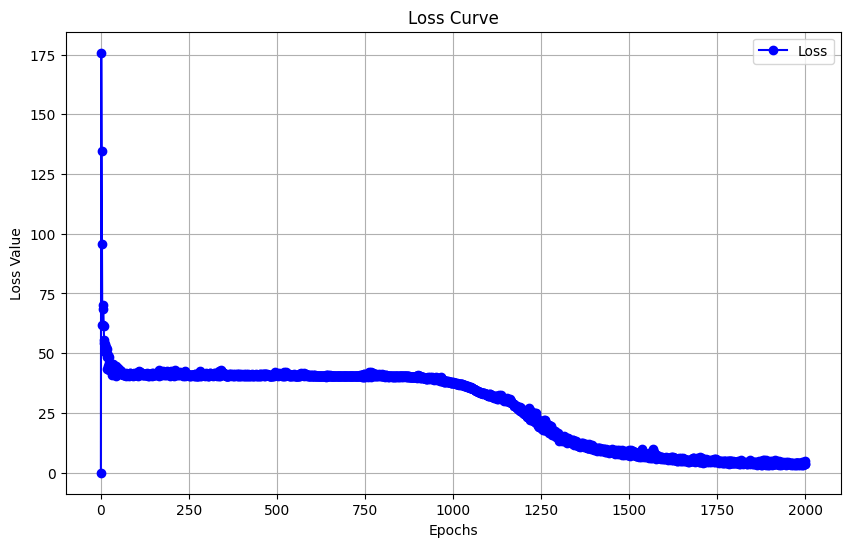

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(Loss, color='blue', marker='o', label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.grid()
plt.legend()
plt.show()

## Predicting process           

In [8]:
# test data set
data = sio.loadmat('./PINN_data/layer_5Hz_test_data.mat')
x_test = data['x_star']
sx_test = data['sx_star']
z_test = data['z_star']
dU_real = data['dU_real_star']
dU_imag = data['dU_imag_star']

x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=False).to(device)
z_test = torch.tensor(z_test, dtype=torch.float32, requires_grad=False).to(device)
sx_test = torch.tensor(sx_test, dtype=torch.float32, requires_grad=False).to(device)
dU_real = torch.tensor(dU_real, dtype=torch.float32, requires_grad=False).to(device)
dU_imag = torch.tensor(dU_imag, dtype=torch.float32, requires_grad=False).to(device)

Net.eval() 
input_test = torch.cat([x_test,z_test,sx_test],-1)
input_test = pos_enc(input_test)

with torch.no_grad():
    du_real, du_imag = Net(input_test)
    accs_real = (torch.pow((dU_real-du_real),2)).mean().item()
    accs_imag = (torch.pow((dU_imag-du_imag),2)).mean().item()

print('step:', step + 1, 'Training accs for real:', accs_real)
print('step:', step + 1, 'Training accs for imag:', accs_imag)

step: 2000 Training accs for real: 0.00011195652768947184
step: 2000 Training accs for imag: 0.00013159189256839454


## Plot reference and predicted wavefields

In [9]:
dU_imag = dU_imag.reshape(41, 41).cpu().numpy()
dU_real = dU_real.reshape(41, 41).cpu().numpy()
du_imag = du_imag.reshape(41, 41).cpu().numpy()
du_real = du_real.reshape(41, 41).cpu().numpy()
diff_imag = dU_imag-du_imag
diff_real = dU_real-du_real

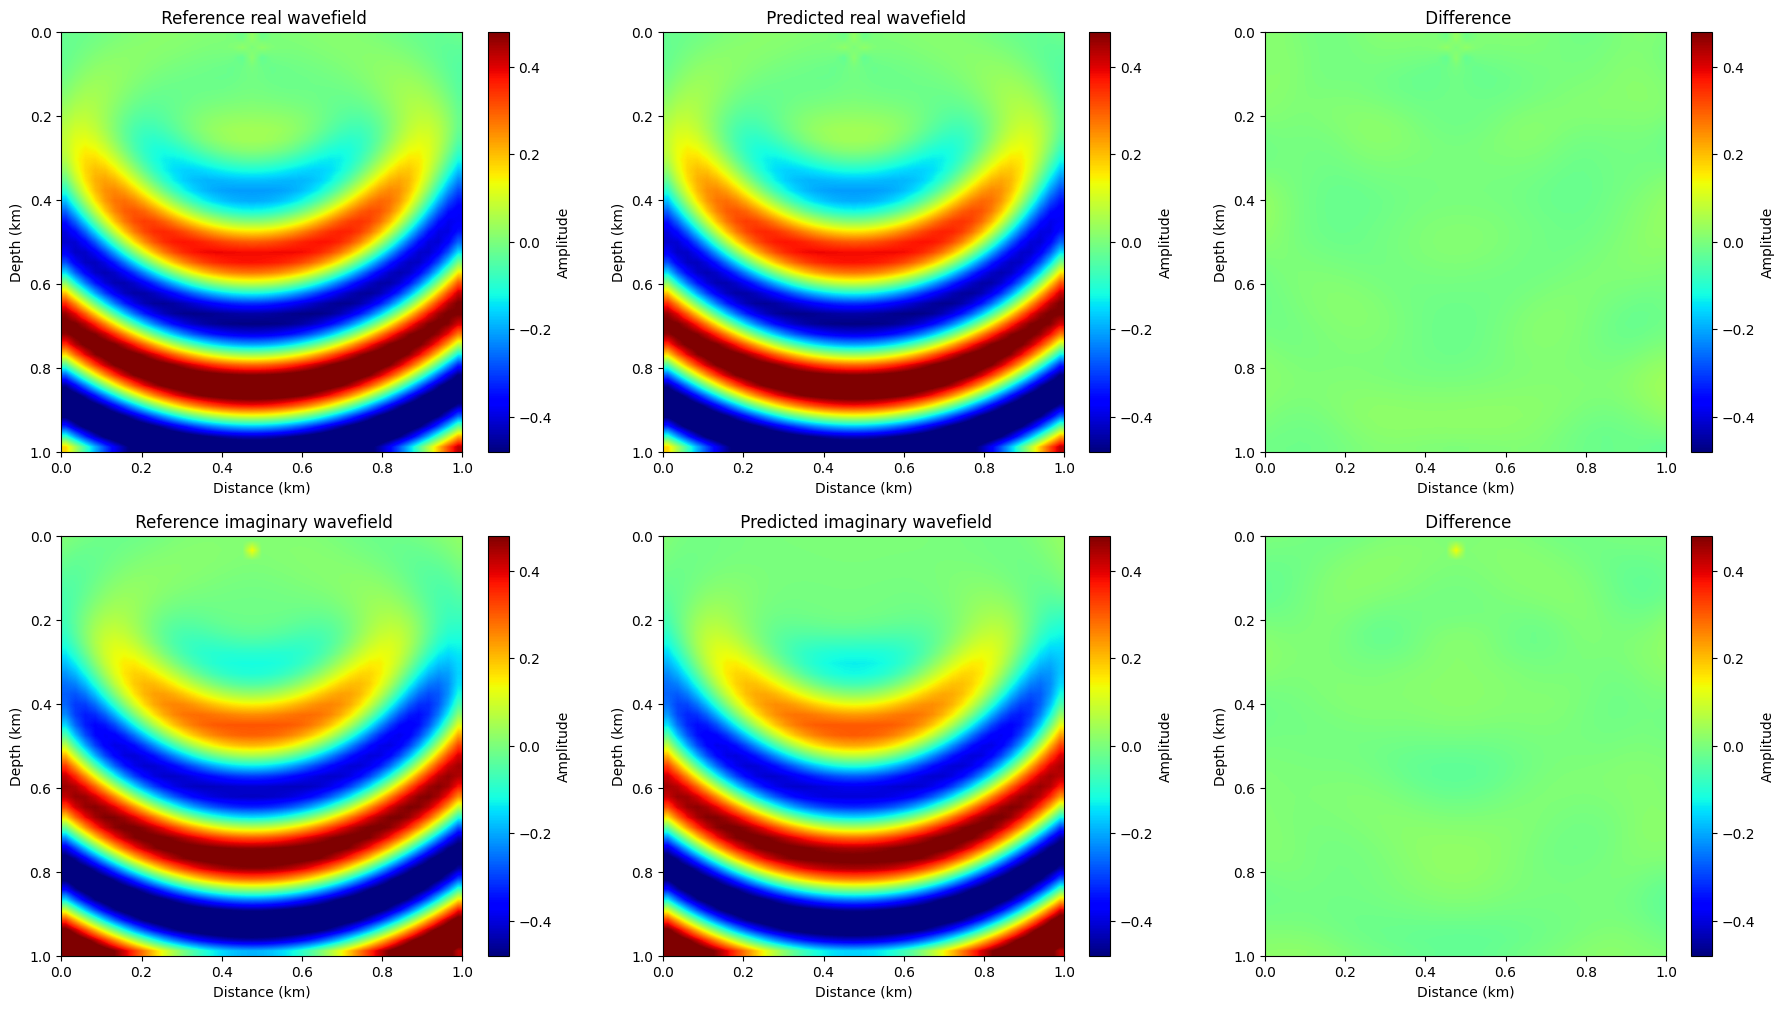

In [10]:
vmin = -0.48
vmax = 0.48

fig, ax = plt.subplots(2, 3, figsize=(22, 12))

cax = ax[0, 0].imshow(dU_real.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[0, 0], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[0, 0].set_title(" Reference real wavefield")
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Depth (km)')

cax = ax[0, 1].imshow(dU_real.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[0, 1], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[0, 1].set_title(" Predicted real wavefield")
ax[0, 1].set_xlabel('Distance (km)')
ax[0, 1].set_ylabel('Depth (km)')

cax = ax[0, 2].imshow(diff_real.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[0, 2], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[0, 2].set_title(" Difference")
ax[0, 2].set_xlabel('Distance (km)')
ax[0, 2].set_ylabel('Depth (km)')

cax = ax[1, 0].imshow(dU_imag.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[1, 0], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[1, 0].set_title(" Reference imaginary wavefield")
ax[1, 0].set_xlabel('Distance (km)')
ax[1, 0].set_ylabel('Depth (km)')

cax = ax[1, 1].imshow(du_imag.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[1, 1], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[1, 1].set_title(" Predicted imaginary wavefield")
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Depth (km)')

cax = ax[1, 2].imshow(diff_imag.T, aspect='auto', cmap='jet', interpolation='bilinear', extent=[0, 1, 1, 0],vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax, ax=ax[1, 2], shrink=1,ticks=[-0.4, -0.2, 0, 0.2, 0.4], label='Amplitude')
ax[1, 2].set_title(" Difference")
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].set_ylabel('Depth (km)')

plt.show()